<a href="https://colab.research.google.com/github/gomescheelsy03/INST-414-0101-/blob/main/Enrollment_by_Gender_(Fall_2014_vs_2024).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Name: Chelsy Mary Gomes
# INST 414 (0101)
# Instructor: Cody Buntain
# A1 – Exploratory Analysis
# Due: 09/19/2025

In [5]:
# === Setup ===
import os, re, glob
import pandas as pd
import matplotlib.pyplot as plt

os.makedirs("data", exist_ok=True)
os.makedirs("figs", exist_ok=True)

print("If your CSVs are already in the Files pane, great.")
print("If not, the next cell will ask you to upload 2014 and 2024.")


If your CSVs are already in the Files pane, great.
If not, the next cell will ask you to upload 2014 and 2024.


In [6]:
# === Find the 2014 & 2024 CSVs, or prompt upload ===
def ensure_two_csvs():
    local = glob.glob("*.csv")
    got = {}
    for f in local:
        if "2014" in f: got[2014] = f
        if "2024" in f: got[2024] = f

    missing = {2014, 2024} - set(got.keys())
    if missing:
        from google.colab import files  # prompts only in Colab
        while missing:
            print(f"Please upload CSV(s) for: {sorted(missing)} (you can select multiple files)")
            up = files.upload()
            for name in up.keys():
                if name.lower().endswith(".csv"):
                    if "2014" in name: got[2014] = name
                    if "2024" in name: got[2024] = name
            missing = {2014, 2024} - set(got.keys())
    return got[2014], got[2024]

csv2014, csv2024 = ensure_two_csvs()
print("Using:", csv2014, "and", csv2024)


Using: Statewide Headcount Enrollment Gender by Ethnicity 2014.csv and Statewide Headcount Enrollment Gender by Ethnicity 2024.csv


In [14]:
# === Helpers: robust parsing for matrix-like CSVs with messy headers ===

def to_str(x):  # safe string
    return "" if pd.isna(x) else str(x)

def clean_num(x):  # "21,209" -> 21209; blanks -> 0
    s = to_str(x).replace(",", "").strip()
    return int(s) if s.isdigit() else 0

def find_umcp_col(df, search_rows=50):

    # Find the column index whose header/early rows contain 'College Park' or 'UMCP'.
    # Works even if all headers are 'Unnamed'.

    nrows, ncols = df.shape
    for j in range(ncols):
        for i in range(min(search_rows, nrows)):
            cell = to_str(df.iat[i, j]).lower()
            if "college park" in cell or re.search(r"\bumcp\b", cell) or "university of maryland" in cell:
                return j, cell
    return None, None

def find_row(df, patterns, search_cols=6, search_rows=600):
    """
    Find the row index whose left few columns contain any of the given patterns.
    patterns: list of lowercase regex strings, e.g. ["total males"]
    """
    nrows, ncols = df.shape
    for i in range(min(search_rows, nrows)):
        row_text = " ".join(to_str(df.iat[i, k]).lower() for k in range(min(search_cols, ncols)))
        if any(re.search(p, row_text) for p in patterns):
            return i, row_text
    return None, None

def extract_umcp_from_matrix_csv(csv_path):
    """
      1) read with NO header
      2) locate the UMCP column index
      3) locate the 'Total Males' / 'Total Females' / 'Gender Unknown' / 'Grand Total' rows
      4) pull the UMCP values from those rows
    """
    df0 = pd.read_csv(csv_path, header=None, dtype=str, keep_default_na=False, engine="python")
    # 1) UMCP column
    umcp_col, umcp_hit = find_umcp_col(df0, search_rows=60)
    if umcp_col is None:
        raise ValueError(f"Couldn't find a UMCP column in {csv_path}. "
                         f"Hint: make sure the file actually contains 'College Park' or 'UMCP' in early rows.")

    # 2) Target rows
    r_male,   txt_m = find_row(df0, [r"total males"])
    r_female, txt_f = find_row(df0, [r"total females"])
    r_unk,    txt_u = find_row(df0, [r"total unknown", r"gender unknown", r"unknown total"])
    r_grand,  txt_g = find_row(df0, [r"grand total"])

    if None in [r_male, r_female, r_unk]:
        raise ValueError(f"Couldn't find one of the total rows in {csv_path}. "
                         f"Check that it has 'Total Males', 'Total Females', 'Total Unknown/Gender Unknown'.")

    # 3) Read the UMCP cell values
    male   = clean_num(df0.iat[r_male,   umcp_col])
    female = clean_num(df0.iat[r_female, umcp_col])
    unk    = clean_num(df0.iat[r_unk,    umcp_col])

    # Optional: sanity print
    print(f"[{os.path.basename(csv_path)}] UMCP col @{umcp_col} via '{umcp_hit}'")
    print(f"  Total Males row -> {male}")
    print(f"  Total Females row -> {female}")
    print(f"  Total Unknown row -> {unk}")
    if r_grand is not None:
        grand = clean_num(df0.iat[r_grand, umcp_col])
        print(f"  Grand Total row (report) -> {grand}  (should equal Male+Female)")
    return male, female, unk

def totals_to_tidy(year, male, female, unknown):
    return pd.DataFrame([
        {"year": year, "gender": "Male",            "count": male},
        {"year": year, "gender": "Female",          "count": female},
        {"year": year, "gender": "Gender Unknown",  "count": unknown},
    ])


In [8]:
# === Extract from each CSV & save tidy data ===
m14, f14, u14 = extract_umcp_from_matrix_csv(csv2014)
m24, f24, u24 = extract_umcp_from_matrix_csv(csv2024)

df = pd.concat([
    totals_to_tidy(2014, m14, f14, u14),
    totals_to_tidy(2024, m24, f24, u24),
], ignore_index=True).sort_values(["year","gender"])

df.to_csv("data/umcp_gender_2014_2024.csv", index=False)
print("Saved -> data/umcp_gender_2014_2024.csv")
df


[Statewide Headcount Enrollment Gender by Ethnicity 2014.csv] UMCP col @9 via 'umcp'
  Total Males row -> 1808
  Total Females row -> 4468
  Total Unknown row -> 134
  Grand Total row (report) -> 6276  (should equal Male+Female)
[Statewide Headcount Enrollment Gender by Ethnicity 2024.csv] UMCP col @9 via 'umcp'
  Total Males row -> 1852
  Total Females row -> 4784
  Total Unknown row -> 125
  Grand Total row (report) -> 6636  (should equal Male+Female)
Saved -> data/umcp_gender_2014_2024.csv


,year,gender,count
1,2014,Female,4468
2,2014,Gender Unknown,134
0,2014,Male,1808
4,2024,Female,4784
5,2024,Gender Unknown,125
3,2024,Male,1852


In [9]:
# === Derive totals & checks ===
wide = df.pivot_table(index="year", columns="gender", values="count", aggfunc="sum").fillna(0)
for c in ["Male","Female","Gender Unknown"]:
    if c not in wide.columns: wide[c] = 0

# USM 'Grand Total' = Male + Female (UNKNOWN EXCLUDED)
wide["grand_total_reported"] = (wide["Male"] + wide["Female"]).astype(int)
# True headcount = Male + Female + Unknown
wide["true_headcount"] = (wide["Male"] + wide["Female"] + wide["Gender Unknown"]).astype(int)

# Shares (of Grand Total)
wide["Male_share_of_grand"]   = (wide["Male"]   / wide["grand_total_reported"]).round(4)
wide["Female_share_of_grand"] = (wide["Female"] / wide["grand_total_reported"]).round(4)

# Validate
assert (df["count"] >= 0).all(), "Negative counts found."
for y in wide.index:
    assert wide.loc[y,"grand_total_reported"] == wide.loc[y,"Male"] + wide.loc[y,"Female"], f"Grand Total mismatch {y}"

# Growth printout
def pct(a,b): return round((b-a)/a*100,1) if a else float("nan")
y0, y1 = min(wide.index), max(wide.index)
print(f"Grand Total (M+F): {wide.loc[y0,'grand_total_reported']:,} → {wide.loc[y1,'grand_total_reported']:,}  "
      f"Δ {wide.loc[y1,'grand_total_reported']-wide.loc[y0,'grand_total_reported']:,}  "
      f"({pct(wide.loc[y0,'grand_total_reported'], wide.loc[y1,'grand_total_reported'])}%)")
print(f"True Headcount (incl Unknown): {wide.loc[y0,'true_headcount']:,} → {wide.loc[y1,'true_headcount']:,}  "
      f"Δ {wide.loc[y1,'true_headcount']-wide.loc[y0,'true_headcount']:,}  "
      f"({pct(wide.loc[y0,'true_headcount'], wide.loc[y1,'true_headcount'])}%)")

# Save summary for Medium/GitHub
summary = wide.reset_index()
summary["Male_share_of_grand"]   = (summary["Male_share_of_grand"]*100).round(1).astype(str) + "%"
summary["Female_share_of_grand"] = (summary["Female_share_of_grand"]*100).round(1).astype(str) + "%"
summary.to_csv("data/umcp_gender_summary_table.csv", index=False)
print("Saved -> data/umcp_gender_summary_table.csv")

summary[["year","Male","Female","Gender Unknown","grand_total_reported",
         "true_headcount","Male_share_of_grand","Female_share_of_grand"]]


Grand Total (M+F): 6,276 → 6,636  Δ 360  (5.7%)
True Headcount (incl Unknown): 6,410 → 6,761  Δ 351  (5.5%)
Saved -> data/umcp_gender_summary_table.csv


gender,year,Male,Female,Gender Unknown,grand_total_reported,true_headcount,Male_share_of_grand,Female_share_of_grand
0,2014,1808,4468,134,6276,6410,28.8%,71.2%
1,2024,1852,4784,125,6636,6761,27.9%,72.1%


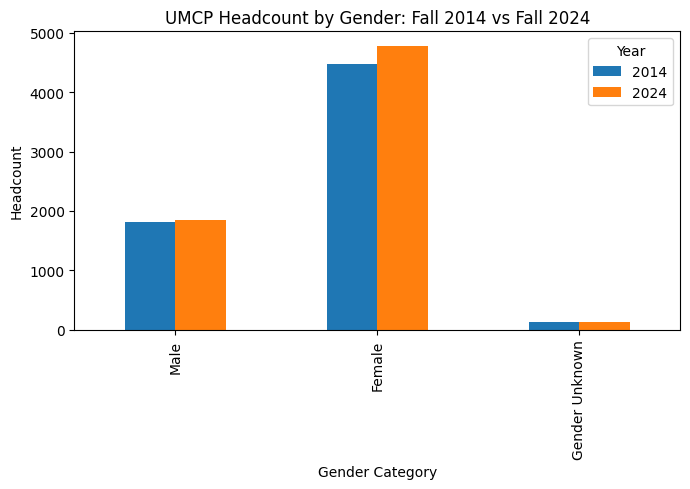

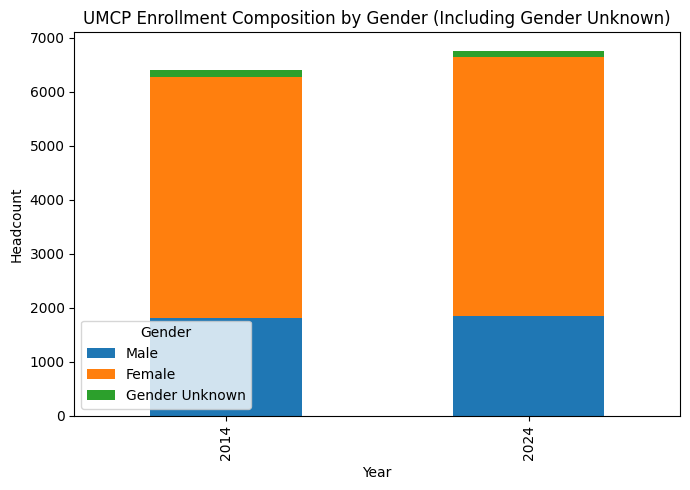

Saved figures -> figs/umcp_gender_grouped_bar.png, figs/umcp_gender_stacked_bar.png


In [11]:
# === Charts ===
# 1) Grouped bars
pivot = df.pivot(index="gender", columns="year", values="count").reindex(["Male","Female","Gender Unknown"])
ax = pivot.plot(kind="bar", figsize=(7,5))
ax.set_title("UMCP Headcount by Gender: Fall 2014 vs Fall 2024")
ax.set_xlabel("Gender Category")
ax.set_ylabel("Headcount")
ax.legend(title="Year")
plt.tight_layout()
plt.savefig("figs/umcp_gender_grouped_bar.png", dpi=150)
plt.show()

# 2) Stacked composition
comp = df.pivot(index="year", columns="gender", values="count")[["Male","Female","Gender Unknown"]]
ax2 = comp.plot(kind="bar", stacked=True, figsize=(7,5))
ax2.set_title("UMCP Enrollment Composition by Gender (Including Gender Unknown)")
ax2.set_xlabel("Year")
ax2.set_ylabel("Headcount")
ax2.legend(title="Gender")
plt.tight_layout()
plt.savefig("figs/umcp_gender_stacked_bar.png", dpi=150)
plt.show()

print("Saved figures -> figs/umcp_gender_grouped_bar.png, figs/umcp_gender_stacked_bar.png")
